# Wine quality prediction pipeline

## Preprocessing

In [3]:
import pandas as pd

df = pd.read_csv('data/winequality-white.csv', sep=";")
print(f"Size of dataset: {df.shape[0]} records")
df.head()

Size of dataset: 4898 records


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Exploring values

Checking if `null` is presented (project page claims, there is no missing values)

In [5]:
df.isnull().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
ph                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

Explore target (wine quality) and its distributions

In [6]:
df['quality'].describe()

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

<Axes: xlabel='quality', ylabel='Count'>

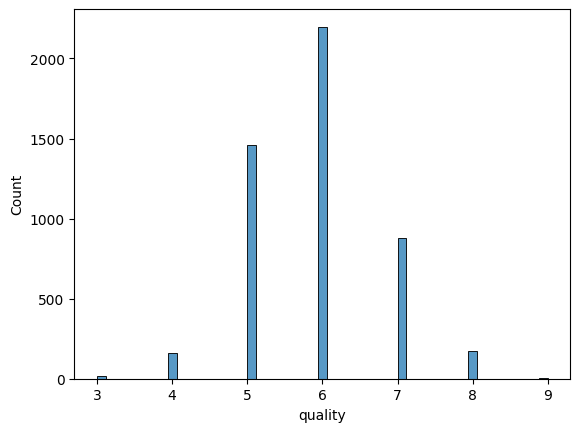

In [7]:
import seaborn as sns
sns.histplot(df['quality'])

We can observe that, most of wines end up in `normal` zone. Because of that task for project will be anomaly detection, when wine is excellent (quality is 8 or higher), as regular classification will ends up in `normal` zone most of the time

For this we introduce new columns `is_excellent` and drop current `quality` columns,in order to avoid data leakage.

In [8]:
df['is_excellent'] = df['quality'] >= 8
df = df.drop(columns=['quality'])
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,is_excellent
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,False
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,False
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,False
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,False
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,False


### Feature selection

As mention on dataset page, authors are not sure if all input variables are relevant, so we have to observe correlation and importance of features.

First, we observe correlation between features - that allows too drop highly correlated features and drop them, to reduce redundancy.

Next, we train some model, to observe important and not important features.

Dropping this mostly useless features, allow to simplify final model, increase training speed and model weight.

<Axes: >

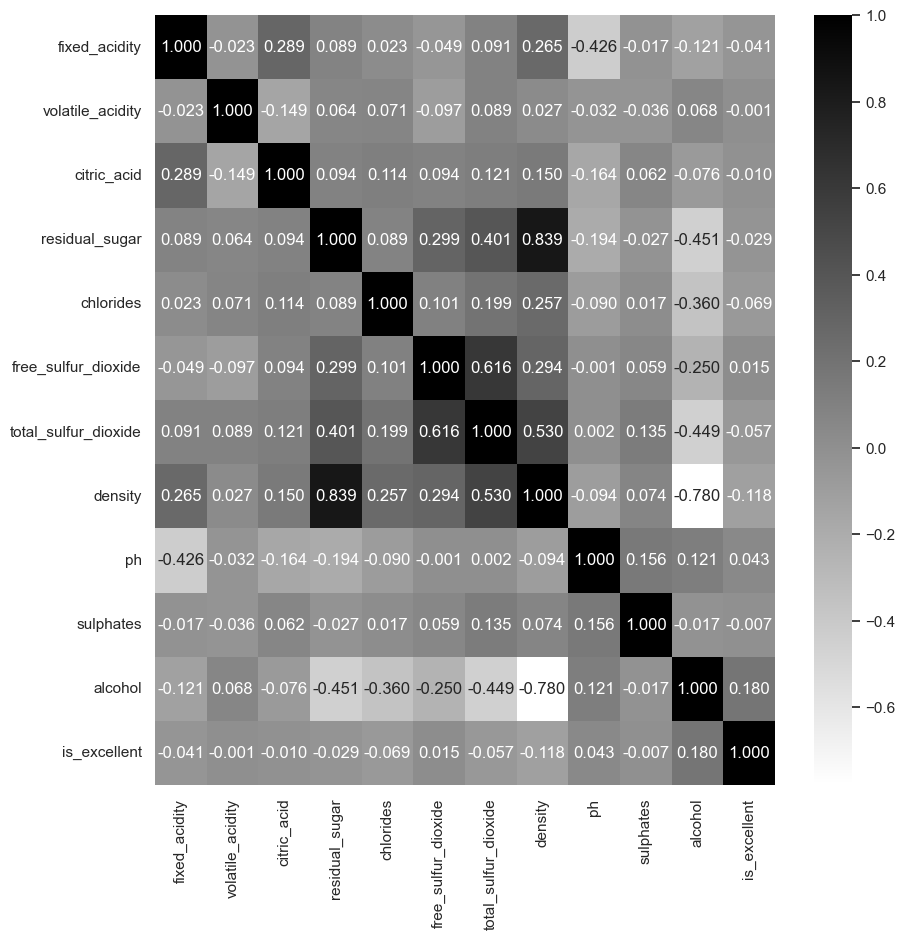

In [9]:
correlation_matrix = df.corr()

sns.set_theme(rc={'figure.figsize':(10,10)})
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="binary")

From this heatmap we can observe:

* strong correlation (0.616) between `free_sulfur_dioxide` and `total_sulfur_dioxide`
* strong negative correlation (-0.780) between `alcohol` and `density`
* strong correlation (0.839) between `density` and `residual_sugar`


In [11]:
from sklearn.tree import DecisionTreeClassifier

X = df.copy()

y = X['is_excellent']
del X['is_excellent']

# deleting columns with hight correlation

del X['density']
del X['total_sulfur_dioxide']


model = DecisionTreeClassifier()
model.fit(X, y)

df_importance = pd.DataFrame(
    {'columns': X.columns, 'importance': model.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

In [12]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X, y)

importance = model.get_booster().get_score(importance_type='gain')

xgb_importance = pd.DataFrame({
    'columns': list(importance.keys()),
    'gain': list(importance.values())
}).sort_values('gain', ascending=False)

In [13]:
pd.merge(df_importance, xgb_importance, on='columns')

,columns,importance,gain
0,alcohol,0.149045,3.045591
1,free_sulfur_dioxide,0.148682,1.371432
2,residual_sugar,0.129531,1.401976
3,chlorides,0.125902,1.185443
4,volatile_acidity,0.122568,1.595880
5,ph,0.113459,1.409248
6,fixed_acidity,0.082752,1.272368
7,citric_acid,0.065800,1.025409
8,sulphates,0.062261,1.197541


From this table we can observe another candidate for deleting from final dataset - `citric_acid` have both low importance and gain.

Now, when exploration of feature importance is done, we prepare dataset for models training.

In [14]:
df = df.drop(columns=['density', 'total_sulfur_dioxide','citric_acid'])
df.head()

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,ph,sulphates,alcohol,is_excellent
0,7.0,0.27,20.7,0.045,45.0,3.00,0.45,8.8,False
1,6.3,0.30,1.6,0.049,14.0,3.30,0.49,9.5,False
2,8.1,0.28,6.9,0.050,30.0,3.26,0.44,10.1,False
3,7.2,0.23,8.5,0.058,47.0,3.19,0.40,9.9,False
4,7.2,0.23,8.5,0.058,47.0,3.19,0.40,9.9,False


## Model training

For better result we should train multiple models, and use the best of them for final result

### Linear logistic regression

### Random Forest Classifier

### eXtreme Gradient Boosting

### Final model selection

## Final model

In [ ]:
# use full train for best model

In [ ]:
# evaluate full model